In [2]:
%pip install -q transformers
%pip install -q segments-ai

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


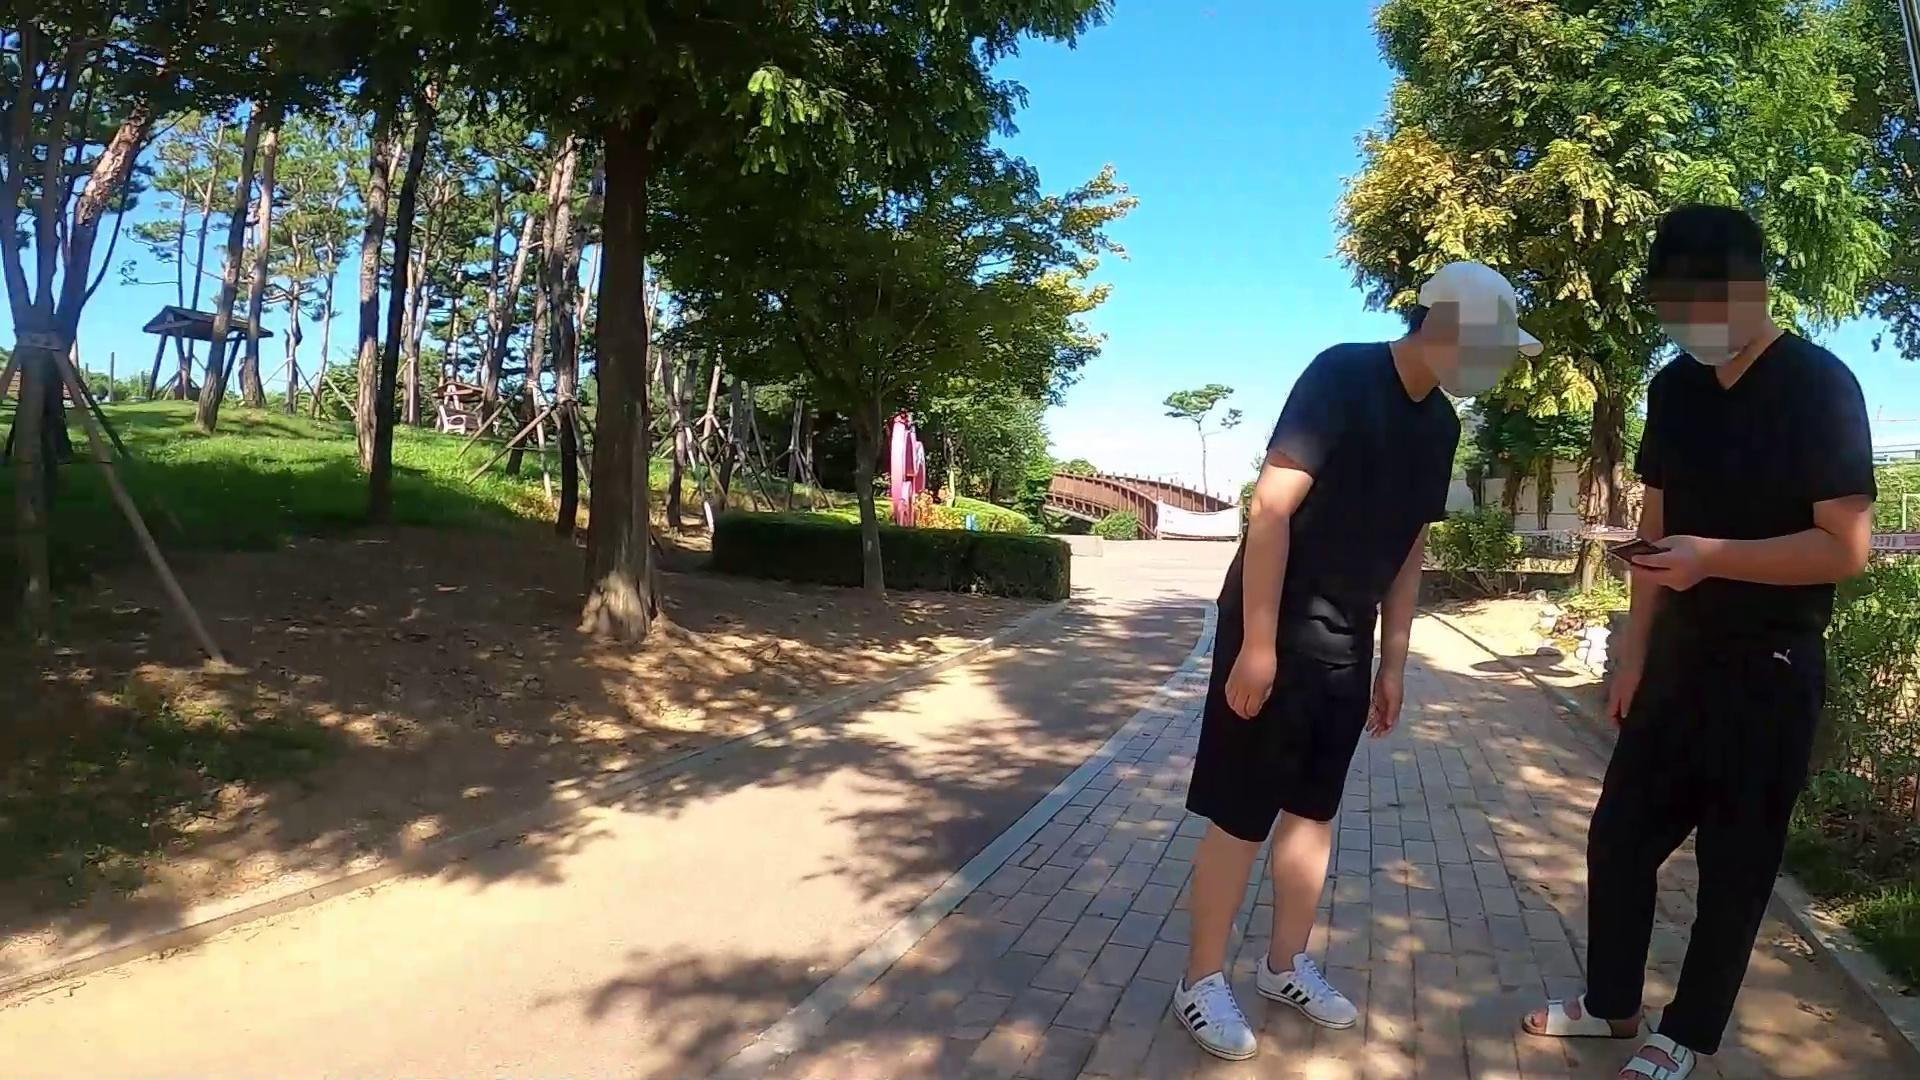

In [7]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

from PIL import Image
import requests

url = "https://img.freepik.com/premium-photo/mockup-of-men-s-hand-holding-white-paper-small-size-cup-with-black-cover_222464-2326.jpg?w=740"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open('images/N-B-P-004_000433.jpg')
image


torch.Size([4, 352, 352])


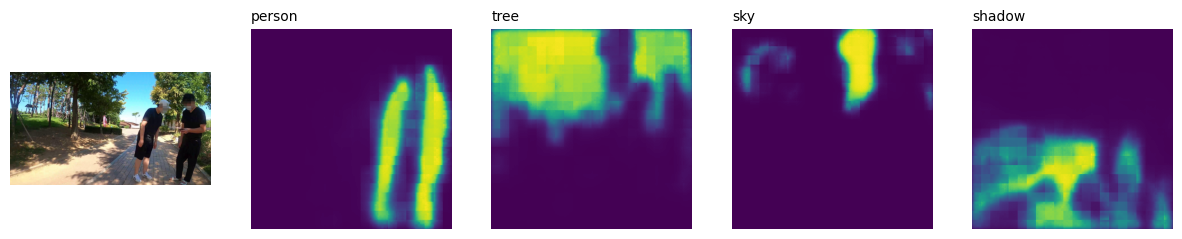

In [8]:
"""
Text prompting
"""

prompts = ['person', 'tree', 'sky', 'shadow']

import torch

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
  
print(outputs.logits.shape)
preds = outputs.logits.unsqueeze(1).cpu()

# visualize
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in  ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];


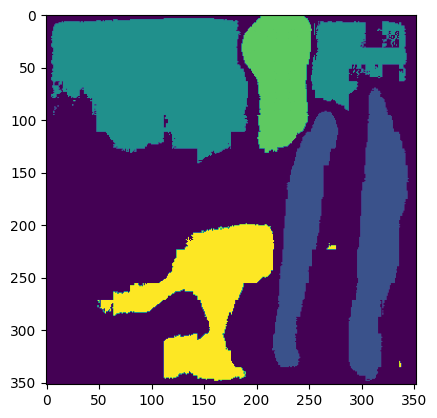

In [9]:
"""
sigmoid 먹여서 segmentation 결과로 변환
"""

threshold = 0.3

flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))

# Initialize a dummy "unlabeled" mask with the threshold
flat_preds_with_treshold = torch.full((preds.shape[0] + 1, flat_preds.shape[-1]), threshold)
flat_preds_with_treshold[1:preds.shape[0]+1,:] = flat_preds

# Get the top mask index for each pixel
inds = torch.topk(flat_preds_with_treshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))

plt.imshow(inds)

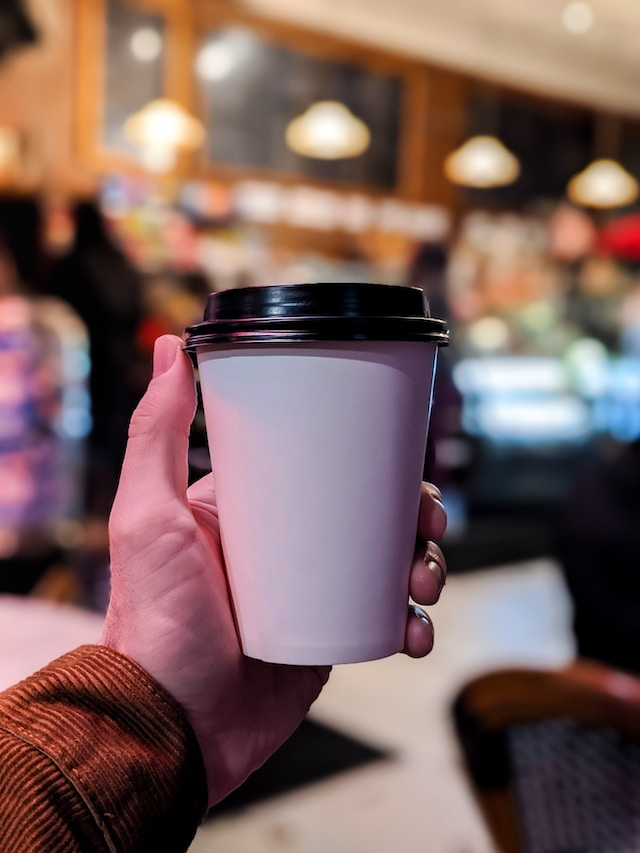

In [ ]:
"""
Visual prompting
"""

url = "https://unsplash.com/photos/Ki7sAc8gOGE/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTJ8fGNvZmZlJTIwdG8lMjBnb3xlbnwwfHx8fDE2NzExOTgzNDQ&force=true&w=640"
prompt = Image.open(requests.get(url, stream=True).raw)
prompt


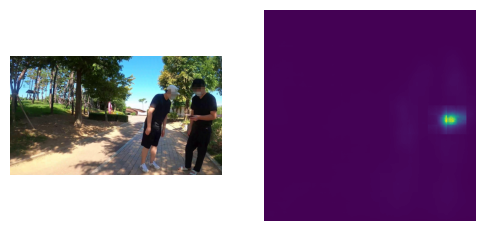

In [ ]:
encoded_image = processor(images=[image], return_tensors="pt")
encoded_prompt = processor(images=[prompt], return_tensors="pt")

# predict
with torch.no_grad():
  outputs = model(**encoded_image, conditional_pixel_values=encoded_prompt.pixel_values)
preds = outputs.logits.unsqueeze(1)
preds = torch.transpose(preds, 0, 1)

# visualize
_, ax = plt.subplots(1, 2, figsize=(6, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
ax[1].imshow(torch.sigmoid(preds[0]))


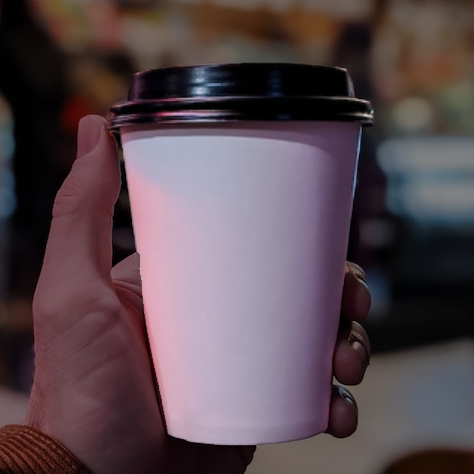

In [ ]:
"""
Image prompt를 좀 더 자명하게 crop하고 배경을 어둡게 하면 더 잘됨
"""

url = "https://i.imgur.com/mRSORqz.jpg"
alternative_prompt = Image.open(requests.get(url, stream=True).raw)
alternative_prompt


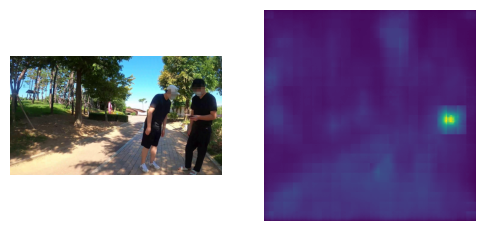

In [ ]:
encoded_alternative_prompt = processor(images=[alternative_prompt], return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**encoded_image, conditional_pixel_values=encoded_alternative_prompt.pixel_values)
preds = outputs.logits.unsqueeze(1)
preds = torch.transpose(preds, 0, 1)

_, ax = plt.subplots(1, 2, figsize=(6, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
ax[1].imshow(torch.sigmoid(preds[0]))


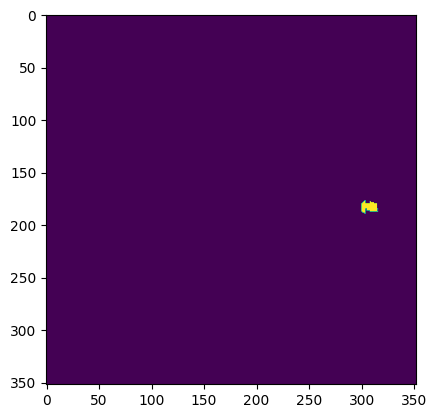

In [ ]:
"""
sigmoid 먹여서 segmentation 결과로 변환
"""

threshold = 0.1

flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))

# Initialize a dummy "unlabeled" mask with the threshold
flat_preds_with_treshold = torch.full((preds.shape[0] + 1, flat_preds.shape[-1]), threshold)
flat_preds_with_treshold[1:preds.shape[0]+1,:] = flat_preds

# Get the top mask index for each pixel
inds = torch.topk(flat_preds_with_treshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))

plt.imshow(inds)

